<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/update_2023/11_hourly_trend_momentum_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hourly trend and momentum simulations

In this notebook, we simulate our trend and momentum strategy with the same parameters as the previous notebook, except now we make a trading decision every hour, instead of every day.

We find that this approach was historically profitable, even after costs, but that there exists a strong short-term mean-reversion effect as well.

**IMPORTANT:**

This notebook requires more RAM than you get on the free version of Colab. One way to run it is to connect to a local Jupyter runtime. [Here are some instructions for doing that](https://robotwealth.com/how-to-connect-google-colab-to-a-local-jupyter-runtime/).

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = TRUE, extra_libraries = c('lubridate', "glue", "tibbletime","roll","RcppRoll","Rcpp", "patchwork"), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into 'C:/Users/Kris/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



package 'pacman' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kris\AppData\Local\Temp\Rtmp8eucBq\downloaded_packages


rlang (1.1.1 -> 1.1.2) [CRAN]
cli   (3.6.1 -> 3.6.2) [CRAN]
vctrs (0.6.3 -> 0.6.5) [CRAN]
purrr (1.0.1 -> 1.0.2) [CRAN]


Installing 4 packages: rlang, cli, vctrs, purrr

Installing packages into 'C:/Users/Kris/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)

Warning message in i.p(...):
"installation of one or more packages failed,
  probably 'rlang', 'cli', 'vctrs', 'purrr'"
Installing package into 'C:/Users/Kris/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)

Warning message in i.p(...):
"installation of package 'C:/Users/Kris/AppData/Local/Temp/Rtmp8eucBq/remotes2a47db115ab/arrow' had non-zero exit status"


In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

In [3]:
# snippet: rw crypto load coincodex data v0.1
market_cap <- rwRtools::crypto_get_coincodex() %>%
  select(Ticker, Date, MarketCapUSD)

# load binance prices
prices <- rwRtools::crypto_get_binance_spot_1h()

ℹ Downloading coincodex_marketcap.feather
✔ Saved coincodex_marketcap.feather to coincodex/coincodex_marketcap.feather  ( 18.5 Mb )




File successfully transferred


ℹ Downloading binance_spot_1h.feather
✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 831.1 Mb )




File successfully transferred


In [4]:
# create binance universe on hourly data
# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# duplicates and others to remove
to_remove <- c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')

# Remove stablecoins and others
prices <- prices %>%
  filter(!Ticker %in% c(stables, to_remove)) %>%
  # retain only the data we need
  select(Ticker, Datetime, Close) %>%
  # ditch USDT part of Ticker
  mutate(Ticker = str_replace(Ticker, "USDT$", "")) %>%
  # take a daily snapshot at a particular time
  mutate(
    Hour = hour(Datetime),
    Date = as_date(Datetime)
  )

  # remove from market_cap data anything that wasn't trading on Binance or is a stable/duplicate
binance_tickers <- pull(prices, Ticker) %>% unique()

market_cap <- market_cap %>%
  filter(!Ticker %in% c(stables, to_remove)) %>%
  filter(Ticker %in% binance_tickers)

# Get first date where we have min_constituents
min_constituents <- 10

start_date <- prices %>%
  group_by(Datetime) %>%
  summarise(count = n()) %>%
  filter(count >= min_constituents) %>%
  summarise(mindate = min(Datetime)) %>%
  pull(mindate)

start_date <- start_date + 1

In [5]:
# Flag universe consitutents
# For a given ticker/date observation, set is_index to TRUE if:
#    - the asset was in the top 10 coins by market cap the day before
#    - the date is on or after the date when we have min_consituents assets in our dataset
n <- 10

binance_universe <- prices %>%
  # this will remove any tickers that were removed from the prices data
  left_join(market_cap, by = c("Ticker", "Date")) %>%
  # where remaining tickers are missing market cap data, fill forward
  group_by(Ticker) %>%
  arrange(Datetime) %>%
  fill(MarketCapUSD, .direction = "down") %>%
  na.omit() %>%
  # but we need to create a new universe based on the remaining binance tickers (not all coincodex tickers were trading on binance)
  group_by(Datetime) %>%
  mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
  arrange(Datetime) %>%
  group_by(Ticker) %>%
  mutate(is_index = lag(cap_rank) <= n & Date >= start_date) %>%
  na.omit() %>%
  ungroup()

In [6]:
tail(binance_universe)

Ticker,Datetime,Close,Hour,Date,MarketCapUSD,cap_rank,is_index
<chr>,<dttm>,<dbl>,<int>,<date>,<dbl>,<int>,<lgl>
YFI,2023-12-11 23:00:00,8.523e+03,23,2023-12-11,286120913,105,FALSE
YGG,2023-12-11 23:00:00,3.492e-01,23,2023-12-11,100522387,180,FALSE
ZEC,2023-12-11 23:00:00,3.061e+01,23,2023-12-11,501931650,70,FALSE
ZEN,2023-12-11 23:00:00,1.024e+01,23,2023-12-11,82162674,191,FALSE
ZIL,2023-12-11 23:00:00,2.254e-02,23,2023-12-11,394754657,83,FALSE
ZRX,2023-12-11 23:00:00,3.814e-01,23,2023-12-11,326135685,94,FALSE


In [7]:
library(Rcpp)
cppFunction(
  code = 'NumericVector ema(NumericVector vec, int window) {
    double smoothing_factor = 2.0;
    double alpha = smoothing_factor/(window + 1);
    double beta = 1.0 - alpha;

    NumericVector ema = {vec[0]};
    if (vec.size() > 0 ) {
      for (int i = 1; i != vec.size(); ++i) { // Start iterating from  + 1 because I need the last value
          ema.push_back((vec[i] * alpha) + (ema[i-1] * beta));

        }
      return ema;
    }
}'
)

rolling_days_since_high_10 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 10*24, na_value = NA),
  otherwise = NA
)

mom_factor_wide <- binance_universe %>%
  group_by(Ticker) %>%
  arrange(Datetime) %>%
  # Close momo factor
  mutate(
    x_mom_9 = log(Close / lag(Close, n = 9*24)),
    x_mom_13 = log(Close / lag(Close, n = 13*24)),
    x_mom_22 = log(Close / lag(Close, n = 22*24)),
  ) %>%
  # Close to SMA factor
  mutate(
    x_psma_11 = Close / roll_meanr(Close, 11*24) - 1,
    x_psma_19 = Close / roll_meanr(Close, 19*24) - 1,
    x_psma_33 = Close / roll_meanr(Close, 33*24) - 1,
  ) %>%
  # SMA ratio factor
  mutate(
    x_smaf_3_17 = roll_meanr(Close, 3*24) / roll_meanr(Close, 17*24) - 1,
    x_smaf_5_28 = roll_meanr(Close, 5*24) / roll_meanr(Close, 28*24) - 1,
  ) %>%
  # Range over recent history
  mutate(
    x_rrp_11 = (Close - roll_meanr(Close, n = 11*24)) / roll_sdr(Close, n = 11*24),
    x_rrp_18 = (Close - roll_meanr(Close, n = 18*24)) / roll_sdr(Close, n = 18*24),
    x_rrp_33 = (Close - roll_meanr(Close, n = 33*24)) / roll_sdr(Close, n = 33*24),
    x_rrp_41 = (Close - roll_meanr(Close, n = 41*24)) / roll_sdr(Close, n = 41*24),
  ) %>%
  # Range
  mutate(
    x_range_12 = (Close - roll_minr(Close, n = 12*24)) / (roll_maxr(Close, n = 12*24) - roll_minr(Close, n = 12*24)),
    x_range_20 = (Close - roll_minr(Close, n = 20*24)) / (roll_maxr(Close, n = 20*24) - roll_minr(Close, n = 20*24)),
    x_range_29 = (Close - roll_minr(Close, n = 29*24)) / (roll_maxr(Close, n = 29*24) - roll_minr(Close, n = 29*24)),
  ) %>%
  # Days since last high factor
  mutate(
    x_dsh_10 = -rolling_days_since_high_10(Close)
  ) %>%
  # Calculate returns
  mutate(
    fwd_return_1 = lead(Close,1) / Close - 1,
    fwd_return_2 = lead(Close,2) / lead(Close, 1) - 1,
    fwd_return_3 = lead(Close,3) / lead(Close, 2) - 1,
    fwd_log_return_1 = log(lead(Close) / Close),
    fwd_log_return_2 = log(lead(Close,2) / lead(Close, 1)),
    fwd_log_return_3 = log(lead(Close,3) / lead(Close, 2))
  ) %>%
  na.omit() %>%
  ungroup()

mom_ranks <- mom_factor_wide %>%
  pivot_longer(starts_with('x_'), names_to = 'feature', values_to = 'value') %>%
  filter(is_index) %>%
  group_by(Datetime, feature) %>%
  mutate(
    rank = row_number(value),
    weight = rank - mean(rank),
    scaled_weight = weight/sum(abs(weight)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  )

mom_factor <- mom_ranks %>%
  group_by(Datetime, feature) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  group_by(feature) %>%
  arrange(Datetime) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  )

`summarise()` has grouped output by 'Datetime'. You can override using the `.groups` argument.


`summarise()` has grouped output by 'Datetime'. You can override using the `.groups` argument.


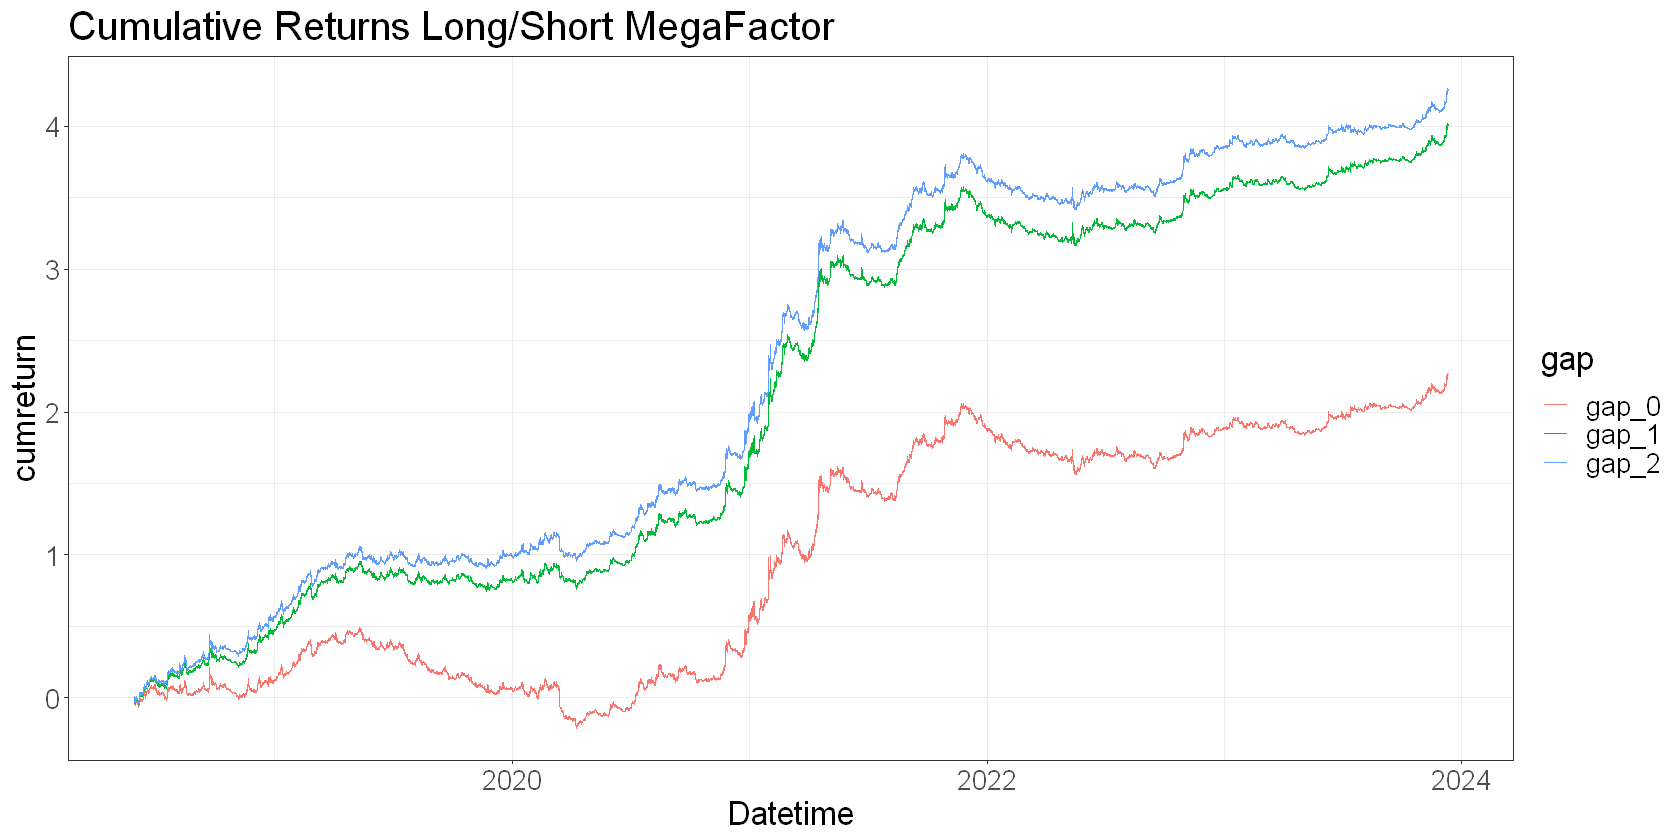

In [8]:
megafactor <- mom_ranks %>%
  group_by(Datetime, Ticker) %>%
  summarise(megafactor = mean(rank))

megafactor_cumreturns <- megafactor %>%
  inner_join(mom_factor_wide,  by = c('Ticker','Datetime')) %>%
  mutate(
    weight = megafactor - mean(megafactor),
    scaled_weight = weight/sum(abs(weight)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  ) %>%
  group_by(Datetime) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  arrange(Datetime) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  ) %>%
  # Rolling returns
  mutate(
    rolling_gap_0 = roll_meanr(log_factor_return_1, 90) * 365,
    rolling_gap_1 = roll_meanr(log_factor_return_2, 90) * 365,
    rolling_gap_2 = roll_meanr(log_factor_return_3, 90) * 365
  )

megafactor_cumreturns %>%
  pivot_longer(starts_with('gap_'), names_to = 'gap', values_to = 'cumreturn') %>%
  ggplot(aes(x=Datetime, y=cumreturn, color = gap)) +
    geom_line() +
    ggtitle('Cumulative Returns Long/Short MegaFactor')

Returns to multi-day cross-sectional momentum features are higher if you wait 2 hours than if you acted on them immediately.

This implies a strong short-term cross-sectional mean-reversion effect.

In [9]:
rolling_days_since_high_12 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 12*24, na_value = NA),
  otherwise = NA
)

rolling_days_since_high_26 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 26*24, na_value = NA),
  otherwise = NA
)

trend_factor_wide <- binance_universe %>%
  group_by(Ticker) %>%
  arrange(Datetime) %>%
  # Price momo factor
  mutate(
    t_mom_23 = log(Close / lag(Close, n = 23*24)),
    t_mom_32 = log(Close / lag(Close, n = 32*24)),
  ) %>%
  # Price to SMA factor
  mutate(
    t_psma_18 = Close / roll_meanr(Close, 18*24) - 1,
    t_psma_29 = Close / roll_meanr(Close, 29*24) - 1,
    t_psma_43 = Close / roll_meanr(Close, 43*24) - 1,
  ) %>%
  # SMA ratio factor
  mutate(
    t_smaf_3_13 = roll_meanr(Close, 3*24) / roll_meanr(Close, 13*24) - 1,
    t_smaf_3_24 = roll_meanr(Close, 3*24) / roll_meanr(Close, 24*24) - 1,
  ) %>%
  # Range over recent history
  mutate(
    t_rrp_8 = (Close - roll_meanr(Close, n = 8*24)) / roll_sdr(Close, n = 8*24),
    t_rrp_17 = (Close - roll_meanr(Close, n = 17*24)) / roll_sdr(Close, n = 17*24),
    t_rrp_31 = (Close - roll_meanr(Close, n = 31*24)) / roll_sdr(Close, n = 31*24),
    t_rrp_38 = (Close - roll_meanr(Close, n = 38*24)) / roll_sdr(Close, n = 38*24),
  ) %>%
  # Range
  mutate(
    t_range_10 = (Close - roll_minr(Close, n = 10*24)) / (roll_maxr(Close, n = 10) - roll_minr(Close, n = 10*24)) - 0.5,
    t_range_21 = (Close - roll_minr(Close, n = 21*24)) / (roll_maxr(Close, n = 21) - roll_minr(Close, n = 21*24)) - 0.5,
    t_range_33 = (Close - roll_minr(Close, n = 33*24)) / (roll_maxr(Close, n = 33) - roll_minr(Close, n = 33*24)) - 0.5,
  ) %>%
  # Days since last high factor
  mutate(
    t_dsh_12 = -rolling_days_since_high_10(Close) + 6*24
  ) %>%
  mutate(
    t_dsh_26 = -rolling_days_since_high_26(Close) + 13*24
  ) %>%
  # Calculate returns
  mutate(
    fwd_return_1 = lead(Close, 1) / Close - 1,
    fwd_return_2 = lead(Close, 2) / lead(Close, 1) - 1,
    fwd_return_3 = lead(Close, 3) / lead(Close, 2) - 1,
    fwd_log_return_1 = log(lead(Close) / Close),
    fwd_log_return_2 = log(lead(Close, 2) / lead(Close, 1)),
    fwd_log_return_3 = log(lead(Close, 3) / lead(Close, 2))
  ) %>%
  na.omit() %>%
  ungroup()

clamp <- 2.5
trend_ranks <- trend_factor_wide %>%
  pivot_longer(starts_with('t_'), names_to = 'feature', values_to = 'value') %>%
  group_by(Ticker, feature) %>%
  arrange(Datetime) %>%
  mutate(
    sd_scalemom = value / roll_sdr(value, 60*24),
    weight = 0.5 * pmax(pmin(sd_scalemom, clamp), -clamp),  # Scale to sit between 1.25 and -1.25
    scaled_weight = 0.1 * weight,                           # 10 assets so divide by 10
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  ) %>%
  filter(is_index) %>%
  na.omit() %>%
  ungroup()

trend_factor <- trend_ranks %>%
  filter(is_index) %>%
  group_by(Datetime, feature) %>%
  summarise(
    weight = sum(scaled_weight),
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  group_by(feature) %>%
  arrange(Datetime) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  )

`summarise()` has grouped output by 'Datetime'. You can override using the `.groups` argument.


`summarise()` has grouped output by 'Datetime'. You can override using the `.groups` argument.


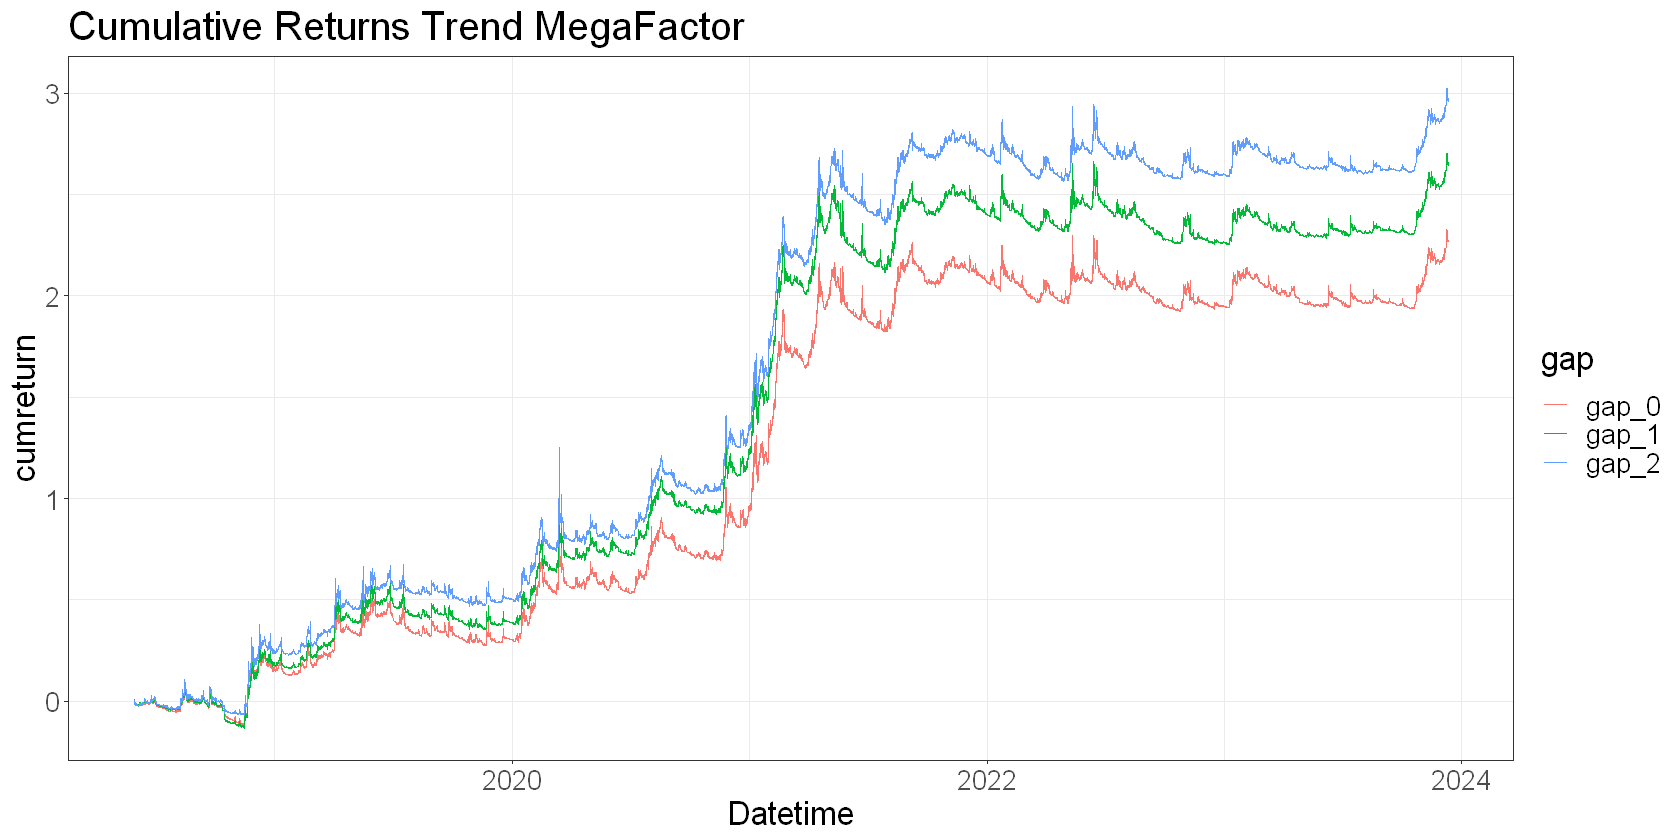

In [11]:
trend_weights <- trend_ranks %>%
  group_by(Datetime, Ticker) %>%
  summarise(scaled_weight = mean(scaled_weight))

trend_weights %>%
  inner_join(trend_factor_wide,  by = c('Ticker','Datetime')) %>%
  mutate(
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  ) %>%
  group_by(Datetime) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  arrange(Datetime) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  ) %>%
  # Rolling returns
  mutate(
    rolling_gap_0 = roll_meanr(log_factor_return_1, 90) * 365,
    rolling_gap_1 = roll_meanr(log_factor_return_2, 90) * 365,
    rolling_gap_2 = roll_meanr(log_factor_return_3, 90) * 365
  ) %>%
  pivot_longer(starts_with('gap_'), names_to = 'gap', values_to = 'cumreturn') %>%
  ggplot(aes(x=Datetime, y=cumreturn, color = gap)) +
    geom_line() +
    ggtitle('Cumulative Returns Trend MegaFactor')

Returns to multi-day time-series trend features are higher if you wait 2 hours than if you acted on them immediately.

This implies a strong short-term time-series mean-reversion effect.

So we see short term mean reversion both in the time series and cross sectionally. We'll come back to this.

## Trend and momentum hourly simulation

In [12]:
momo_weight_scale <- 0.8
trend_weight_scale <- 0.2

comboweight <- megafactor %>%
  inner_join(trend_weights, by = c('Ticker','Datetime')) %>%
  inner_join(mom_factor_wide,  by = c('Ticker','Datetime')) %>%
  mutate(
    weight = megafactor - mean(megafactor),
    momentum_weight = weight/sum(abs(weight))
  ) %>%
  mutate(combo_weight = (momentum_weight * momo_weight_scale) + (trend_weight_scale * scaled_weight))

# get all tickers that were ever in the universe
universe_tickers <- binance_universe %>%
  filter(is_index == TRUE) %>%
  pull(Ticker) %>%
  unique()

print(universe_tickers)

# get start date of simulation (first time we have min constituents)
start_date <- binance_universe %>%
  filter(is_index == TRUE) %>%
  group_by(Datetime) %>%
  summarise(num_tickers = n()) %>%
  filter(num_tickers >= min_constituents) %>%
  summarise(start_date = first(Datetime)) %>%
  pull(start_date)

end_date <- comboweight %>% tail(1) %>% pull(Datetime)

sim_df <- comboweight %>%
  select(Datetime, Ticker, Close, combo_weight) %>%
  # bind prices on days where our universe tickers weren't in the tradable universe
  # this will assign NA to any combo_weight where the ticker wasn't traded
  bind_rows(
    binance_universe %>%
      filter(Ticker %in% universe_tickers, is_index == FALSE) %>%
      select(Datetime, Ticker, Close)
  ) %>%
  # assign 0 for any NA combo_weight
  replace_na(list(combo_weight = 0)) %>%
  # sort by date
  arrange(Datetime, Ticker) %>%
  # remove rows prior to start date
  filter(Datetime >= start_date) %>%
  filter(Datetime <= end_date)

head(sim_df)

# get weights as a wide matrix (could do equal weight, in proportion to factor/signal, top n etc)
# note that date column will get converted to unix timestamp
backtest_weights <- sim_df %>%
  pivot_wider(id_cols = Datetime, names_from = Ticker, values_from = c(Close, combo_weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(Datetime, starts_with("combo_weight")) %>%
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

head(backtest_weights, c(5, 5))

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- sim_df %>%
  pivot_wider(id_cols = Datetime, names_from = Ticker, values_from = c(Close, combo_weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(Datetime, starts_with("Close_")) %>%
  data.matrix()

head(backtest_prices, c(5, 5))

 [1] "ADA"   "BNB"   "BTC"   "EOS"   "ETH"   "LTC"   "NEO"   "QTUM"  "XRP"  
[10] "XLM"   "ONT"   "TRX"   "ETC"   "BCHSV" "XMR"   "LINK"  "XTZ"   "BCH"  
[19] "DASH"  "DOT"   "DOGE"  "THETA" "FIL"   "UNI"   "ICP"   "SOL"   "AVAX" 
[28] "FLOW"  "SHIB"  "MATIC"


Datetime,Ticker,Close,combo_weight
<dttm>,<chr>,<dbl>,<dbl>
2018-05-31 18:00:00,BNB,13.8400,0.31257827
2018-05-31 18:00:00,BTC,7541.9000,0.08970899
2018-05-31 18:00:00,ETH,571.3400,-0.23124792
2018-05-31 18:00:00,LTC,119.0200,-0.11210839
2018-05-31 18:00:00,NEO,52.8500,-0.06784979
2018-05-31 19:00:00,BNB,13.8507,0.33760094


Datetime,combo_weight_BNB,combo_weight_BTC,combo_weight_ETH,combo_weight_LTC
1527760800,0.3125783,0.08970899,-0.2312479,-0.11210839
1527764400,0.3376009,0.06460491,-0.1906449,-0.14071587
1527768000,0.3357993,0.06575189,-0.2119119,-0.10771664
1527771600,0.3402953,0.06260330,-0.2276860,-0.08792231
1527775200,0.3492163,0.05443993,-0.2304496,-0.11334478


Datetime,Close_BNB,Close_BTC,Close_ETH,Close_LTC
1527760800,13.8400,7541.90,571.34,119.02
1527764400,13.8507,7531.97,574.93,119.07
1527768000,13.7499,7539.25,574.28,119.45
1527771600,13.9385,7537.75,572.75,119.50
1527775200,14.0190,7551.44,574.98,119.95


In [13]:
# fees - reasonable approximation of actual binance costs (spread + market impact + commission)
fees <- tribble(
  ~tier, ~fee,
  0, 0.,  # use for cost-free simulations
  1, 0.001,
  2, 0.00075,
  3, 0.0006,
  4, 0.0005,
  5, 0.00042,
  6, 0.00036,
  7, 0.00024
)

# plot equity curve from output of simulation
plot_results <- function(backtest_results, weighting_protocol = "Long-short in proportion to factor rank", trade_on = "close") {
  equity_curve <- backtest_results %>%
    group_by(Date) %>%
    summarise(Equity = sum(Value, na.rm = TRUE))

  fin_eq <- equity_curve %>%
    tail(1) %>%
    pull(Equity)

  init_eq <- equity_curve %>%
    head(1) %>%
    pull(Equity)

  total_return <- (fin_eq/init_eq - 1) * 100
  hours <- nrow(equity_curve)
  ann_return <- total_return * 365*24/hours
  sharpe <- equity_curve %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(365*24)*mean(returns)/sd(returns)) %>%
    pull()

  equity_curve %>%
    ggplot(aes(x = Date, y = Equity)) +
      geom_line() +
      labs(
        title = "Momentum Backtest - Cash Accounting",
        subtitle = glue(
          "{weighting_protocol}, costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on {trade_on}
          {round(total_return, 1)}% total return, {round(ann_return, 1)}% annualised, Sharpe {round(sharpe, 2)}"
        )
      )
}

# calculate sharpe ratio from output of simulation
calc_sharpe <- function(backtest_results) {
  backtest_results %>%
    group_by(Date) %>%
    summarise(Equity = sum(Value, na.rm = TRUE)) %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(365*24)*mean(returns)/sd(returns)) %>%
    pull()
}

### Cost-free, no trade buffer

ticker,Date,Close,Position,Value,Trades,TradeValue,Commission
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cash,4184836-12-31,1.00,10089.1884799,10089.1885,NA,NA,0
BNB,4184836-12-31,13.84,225.8513509,3125.7827,225.8513509,3125.7827,0
BTC,4184836-12-31,7541.90,0.1189475,897.0899,0.1189475,897.0899,0
ETH,4184836-12-31,571.34,-4.0474660,-2312.4792,-4.0474660,-2312.4792,0
LTC,4184836-12-31,119.02,-9.4192903,-1121.0839,-9.4192903,-1121.0839,0
NEO,4184836-12-31,52.85,-12.8381820,-678.4979,-12.8381820,-678.4979,0


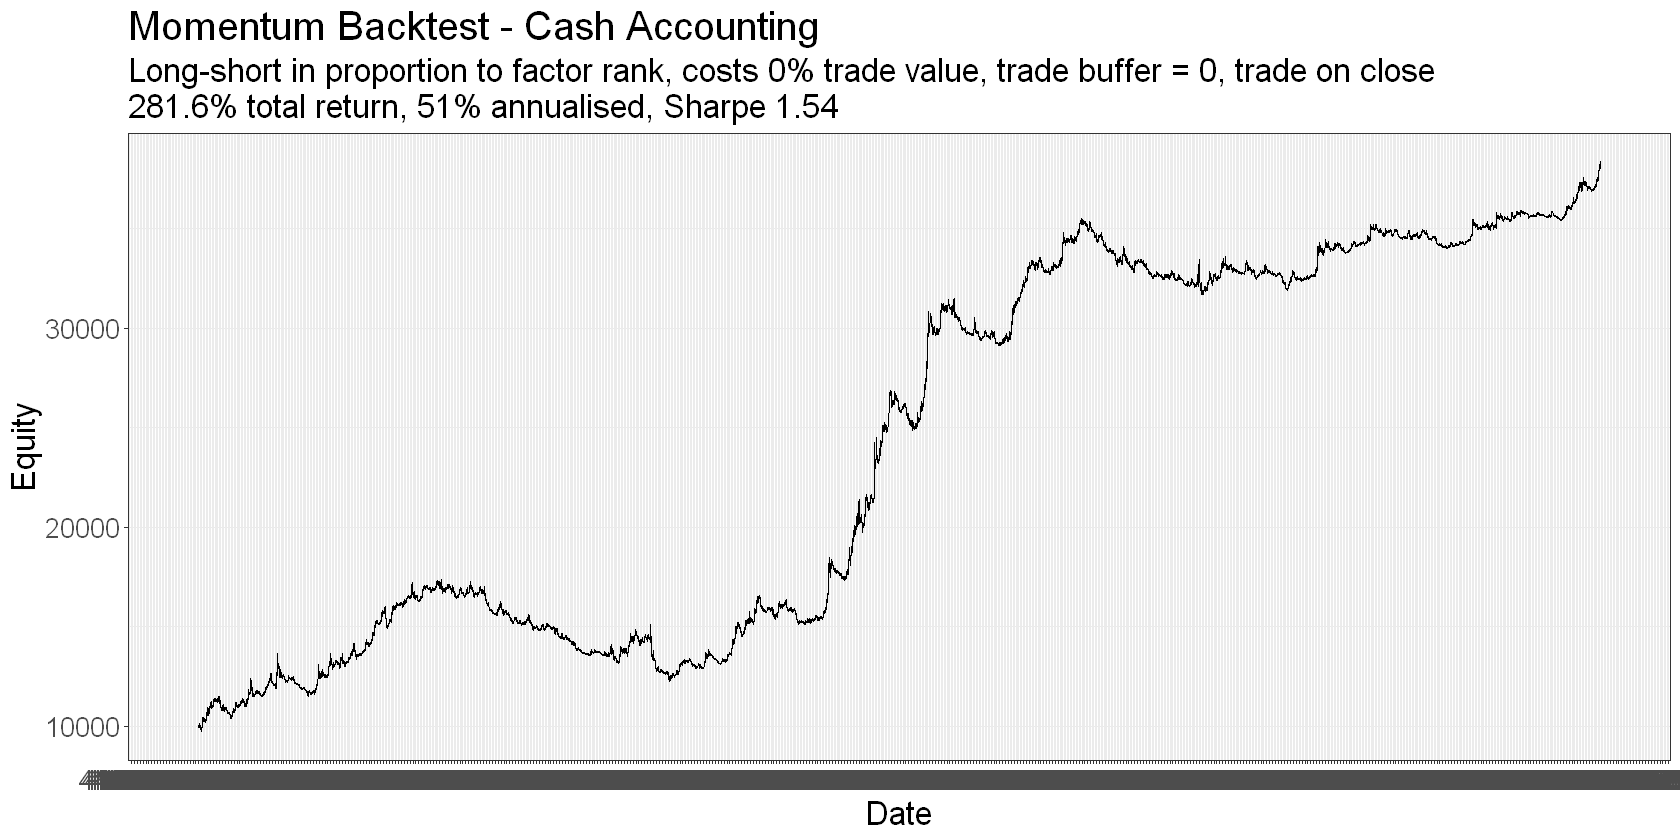

In [14]:
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
fee_tier <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(backtest_prices, backtest_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits) %>%
  mutate(ticker = str_remove(ticker, "Close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

head(results_df)

plot_results(results_df)

### With costs, no trade buffer parameter

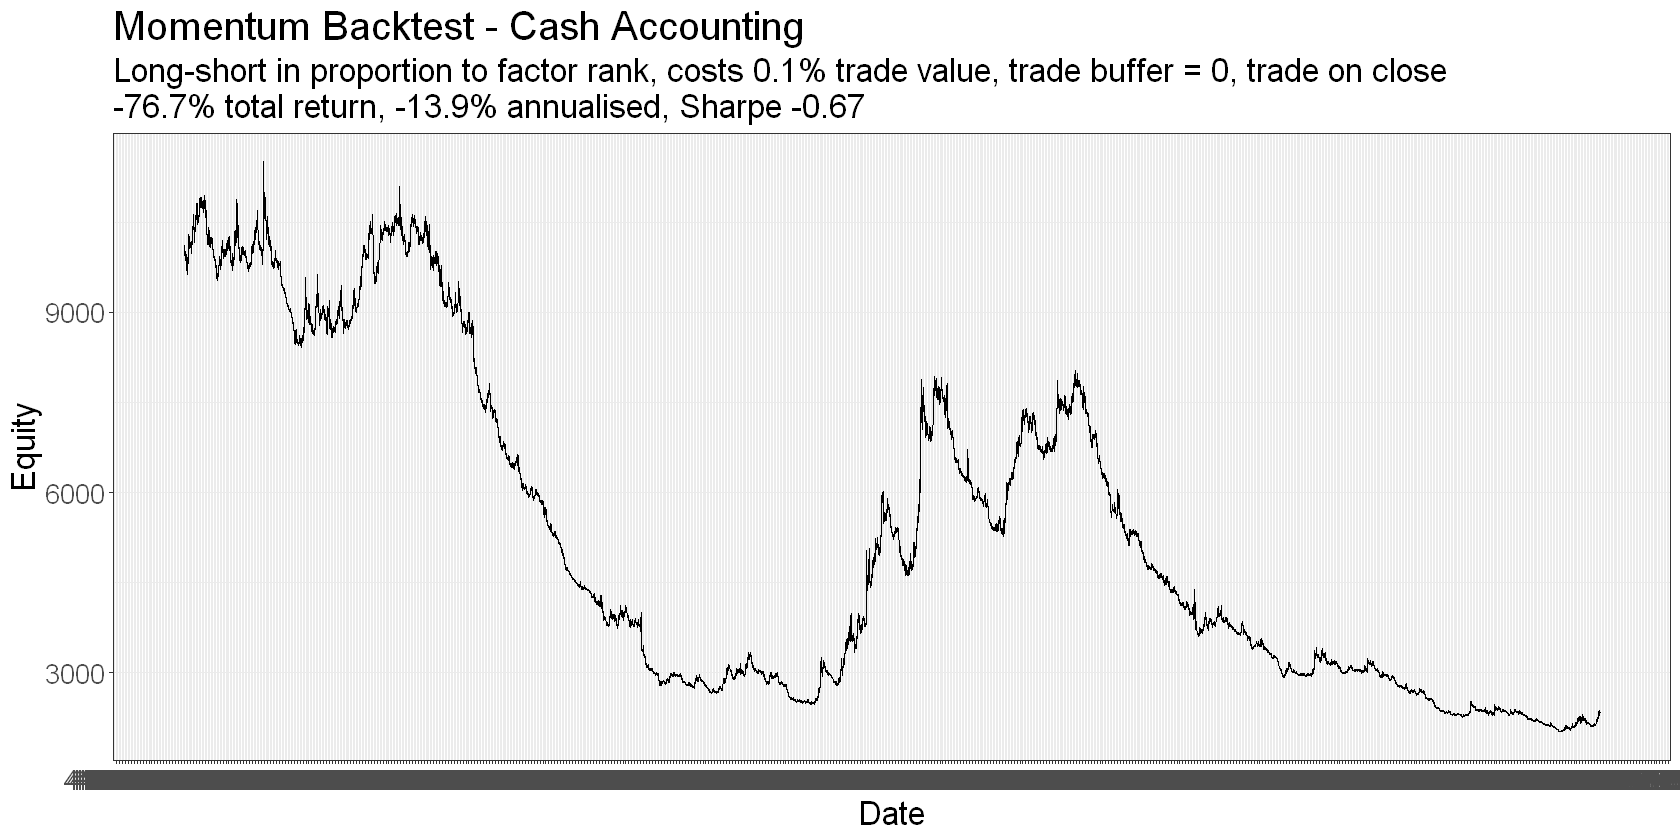

In [15]:
# simulation parameters
fee_tier <- 1.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(
  backtest_prices,
  backtest_weights,
  trade_buffer,
  initial_cash,
  commission_pct,
  capitalise_profits
)

results_df %>%
  plot_results()

Find an appropriate trade buffer parameter by optimising for sharpe ratio



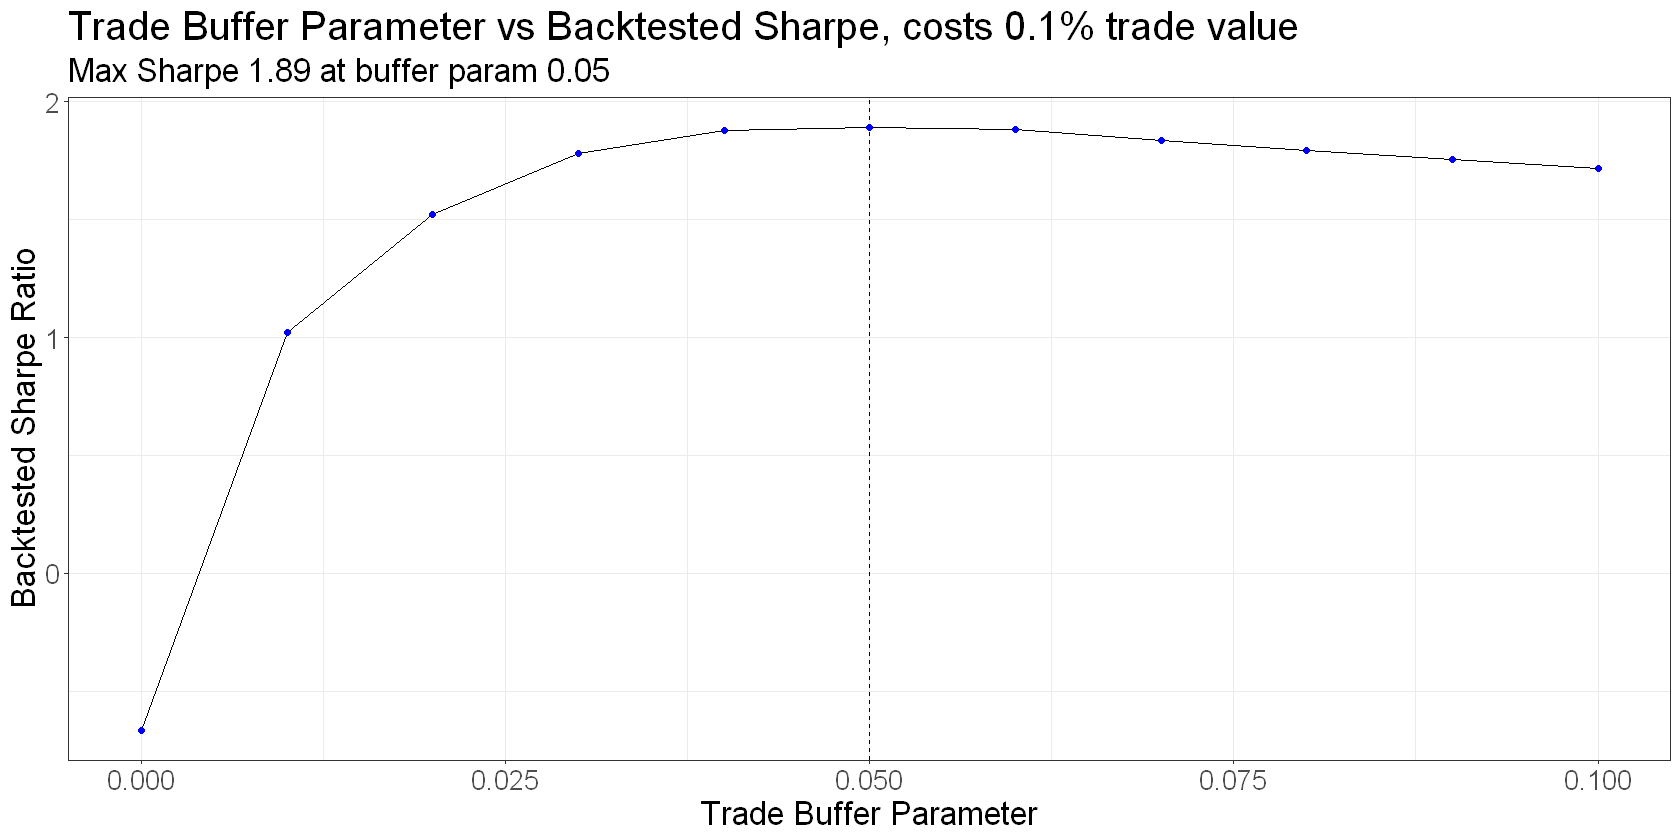

In [16]:
sharpes <- list()
trade_buffers <- seq(0, 0.1, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes,
    cash_backtest(
      backtest_prices,
      backtest_weights,
      trade_buffer,
      initial_cash,
      commission_pct,
      capitalise_profits
    ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers,
  sharpe = sharpes
) %>%
ggplot(aes(x = trade_buffer, y = sharpe)) +
  geom_line() +
  geom_point(colour = "blue") +
  geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
  labs(
    x = "Trade Buffer Parameter",
    y = "Backtested Sharpe Ratio",
    title = glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
    subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
  )

Trading hourly, our optimal trade buffer parameter is 0.05. Let's simulate this:

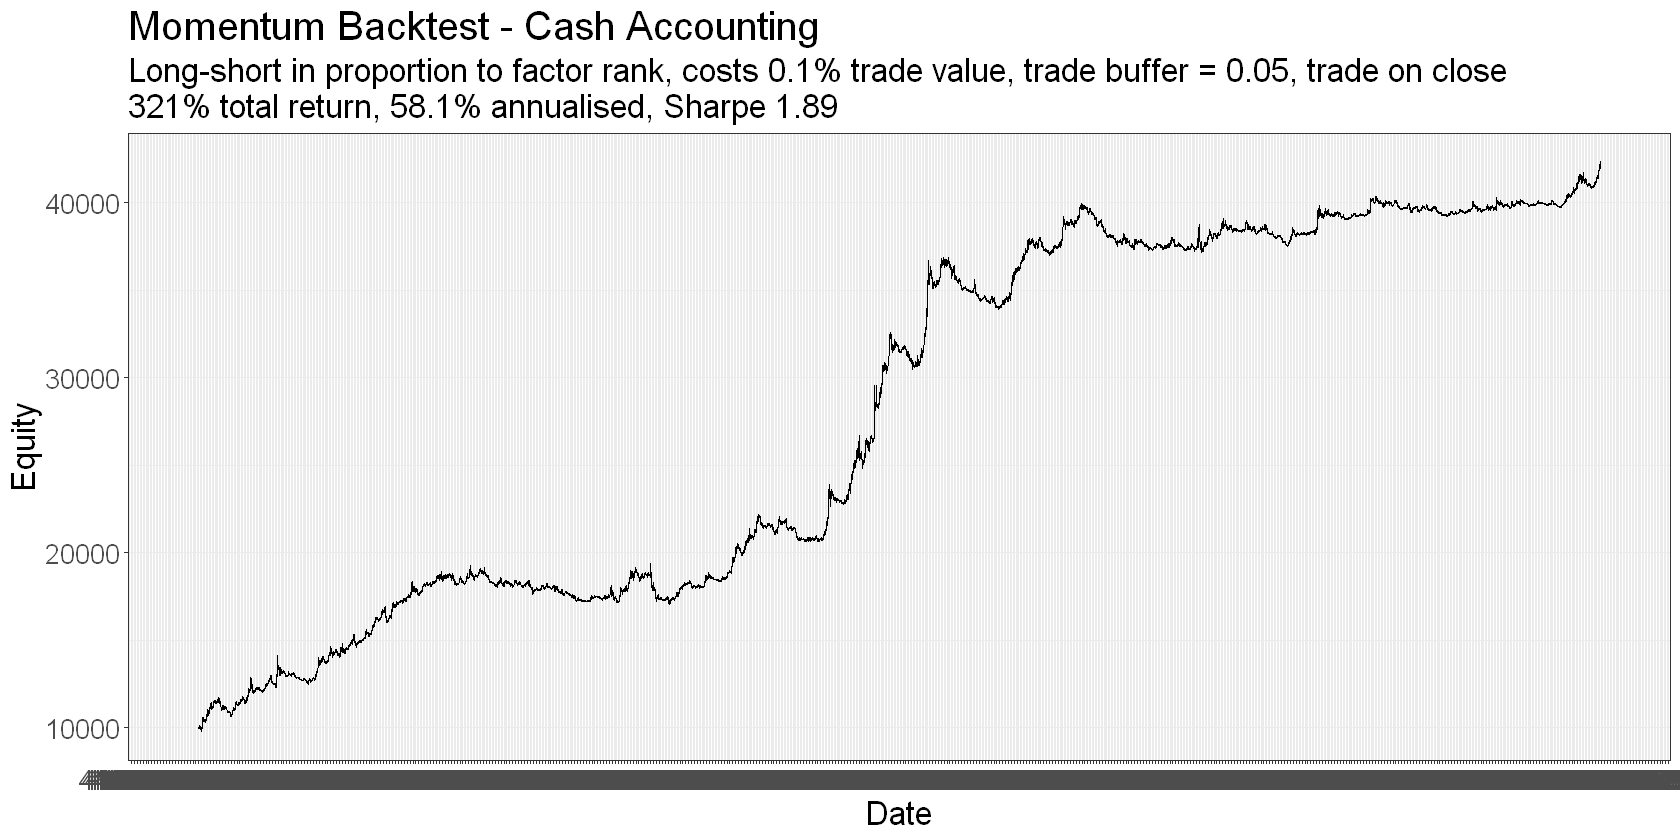

In [18]:
# simulation parameters
fee_tier <- 1.
commission_pct <- fees$fee[fees$tier==fee_tier]
trade_buffer <- 0.05

# simulation
results_df <- cash_backtest(
  backtest_prices,
  backtest_weights,
  trade_buffer,
  initial_cash,
  commission_pct,
  capitalise_profits
)

results_df %>%
  plot_results()

Notice how this outperforms the cost-free no-trade-buffer simulation? That'll be due to the short-term mean-reversion effects we noted previously, and having a trade buffer in place will essentially delay some of our trading.

How would we quantify this short-term mean reversion effect?  
- Momentum feature vs forward returns at various (short) horizons - 1 hour, 2 hours, ... etc
- Use TWAP prices instead of close prices for robustness
